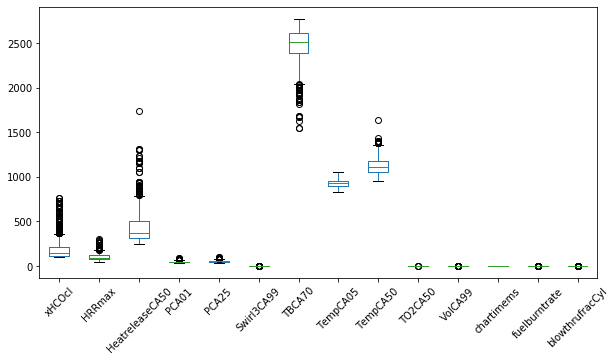

In [1]:
import os
import numpy as np
import torch.nn as nn
import pickle
import random
import pandas as pd
import torch
from torch.autograd import Variable
from pandas_ods_reader import read_ods
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
% matplotlib inline

xHCOcI_thresh = 100
xHCOcI_thresh2 = 900
# Import data start with HCaltitude.ods
num_list = []
path = 'data/HCaltitude.ods'
sheet_idx = 1
df = read_ods(path, sheet_idx)

# Select columns which are common among three data sets
df= df.drop(columns=['Sno', 'HCUDF', 'HCUDFpolynomial'])
columns = list(df.columns)
filter = df['xHCOcI'] > xHCOcI_thresh
df = df.loc[filter]
filter = df['xHCOcI'] < xHCOcI_thresh2
df = df.loc[filter]
data = df[columns]
num_list.append(data.shape[0])

# Import other two kinds of data
paths = ['data/HCDOE.ods']
for path in paths:
    sheet_idx = 1
    df = read_ods(path, sheet_idx)
    df = df[columns]
    filter = df['xHCOcI'] > xHCOcI_thresh
    df = df.loc[filter]
    filter = df['xHCOcI'] < xHCOcI_thresh2

    df = df.loc[filter]
    data = pd.concat([data, df])
    num_list.append(data.shape[0])
data_origin = data.copy()
num_list_origin = num_list.copy()

n1 = num_list[0]
n2 = num_list[1] - num_list[0]

# Visulize filtered data
boxplot = data.boxplot(grid=False, figsize=(10,5), rot=45, return_type='dict')

data = data.to_numpy()

In [2]:
# Scale data to [0,1]
scalerX = preprocessing.MinMaxScaler().fit(data[:, 1:])
scalery = preprocessing.MinMaxScaler().fit(data[:, 0:1])
data[:, 1:] = scalerX.transform(data[:, 1:])
# data[:, 0:1] = scalery.transform(data[:, 0:1])

# HCaltitude as target set
y_target = torch.from_numpy(data[:num_list[0], 0:1]).to(dtype=torch.float32).cuda()
x_target = torch.from_numpy(data[:num_list[0], 1:]).to(dtype=torch.float32).cuda()

# Set the other two sets for training and testing with properation of 7:3
HCDOE = torch.from_numpy(data[num_list[0]:num_list[1], :]).to(dtype=torch.float32).cuda()
training_size = [int(0.7 * n2)]
test_size = [n2 - int(0.7 * n2)]
batch_list = [[item for item in range(training_size[0])]]
chosen_size = [training_size[0] + test_size[0]]

x_training = []
y_training = []
x_test = []
y_test = []

chosen_list = [item for item in range(HCDOE.shape[0])]
random.shuffle(chosen_list)
x_training.append(HCDOE[chosen_list[:training_size[0]], 1:])
y_training.append(HCDOE[chosen_list[:training_size[0]], 0:1])
x_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 1:])
y_test.append(HCDOE[chosen_list[training_size[0]:chosen_size[0]], 0:1])

# Set test sets for different purposes
x_test_0 = x_test[0]
y_test_0 = y_test[0]

# Network structure
class NN(nn.Module):
    def __init__(self, features):
        super(NN, self).__init__()
        self.features = features
        self.l1 = nn.Sequential(
            nn.Linear(self.features, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
#         self.l1 = nn.Sequential(
#             nn.Linear(self.features, 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Linear(128, 1),
#         )
        
    def point_grad_to(self, target):
        '''
        #### This function is important for meta learning. If other model is used, this one could be directly copied into other models ###
        Set .grad attribute of each parameter to be proportional
        to the difference between self and target
        '''
        for p, target_p in zip(self.parameters(), target.parameters()):
            if p.grad is None:
                # if self.is_cuda():
                p.grad = Variable(torch.zeros(p.size())).cuda()
                # else:
                #     p.grad = Variable(torch.zeros(p.size()))
            p.grad.data.zero_()  # not sure this is required
            p.grad.data.add_(p.data - target_p.data)
    def forward(self, input):
        output = self.l1(input)
        return output

In [3]:
#### Hyperparameters needed to be set in advance ####
Step = 100000
batch_size = 10
features = x_target.shape[1]
net = NN(features).cuda()

dataset_idx = 0 # 0: DOE, 1: TPA
lrate = 1e-4 # Without meta leraning
optimizer = torch.optim.Adam(net.parameters(), lr=lrate) # Optimizers
    
#####################################################



MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss()
weight_flag = 0

print('Start training')
for step in range(Step): 

    batch_content = random.sample(batch_list[dataset_idx], batch_size)
    x_batch = x_training[dataset_idx][batch_content, :]
    y_batch = y_training[dataset_idx][batch_content]
    # Update process
    y_pred = net(x_batch)
    loss = MSELoss(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Test    
    y_pred = net(x_test_0)
    y_real = y_test_0
#     y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
#     y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
    loss_0 = MSELoss(y_pred, y_real)
    loss_0 = torch.sqrt(loss_0.data)
    
    y_real = y_real.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    A = np.squeeze(y_pred)
    B = np.squeeze(y_real)
    res = B - A
    tot = B - B.mean()
    r = 1 - res.dot(res) / tot.dot(tot)
#     loss_0 = MSELoss(y_pred, y_real) / (torch.mean(y_real) ** 2)
    
    print('epoch: %d || DOE: %f' % (step, r))
    print(loss_0)
    loss = -r
    if step > 10:
        if weight_flag == 0:
            # Save weights
            weight_name = 'out/model_%d.ckpt' % (step)
            torch.save(net.state_dict(), weight_name)
            weight_flag = 1
            best_one = loss.data
        else:
            if loss < best_one:
                weight_name = 'out/model_%d_%.1f.ckpt' % (step, r)
                torch.save(net.state_dict(), weight_name)
                best_one = loss.data

Start training
epoch: 0 || DOE: -2.187826
tensor(227.8947, device='cuda:0')
epoch: 1 || DOE: -2.186587
tensor(227.8504, device='cuda:0')
epoch: 2 || DOE: -2.185354
tensor(227.8063, device='cuda:0')
epoch: 3 || DOE: -2.184090
tensor(227.7611, device='cuda:0')
epoch: 4 || DOE: -2.182791
tensor(227.7147, device='cuda:0')
epoch: 5 || DOE: -2.181448
tensor(227.6666, device='cuda:0')
epoch: 6 || DOE: -2.180052
tensor(227.6167, device='cuda:0')
epoch: 7 || DOE: -2.178608
tensor(227.5650, device='cuda:0')
epoch: 8 || DOE: -2.177081
tensor(227.5103, device='cuda:0')
epoch: 9 || DOE: -2.175469
tensor(227.4526, device='cuda:0')
epoch: 10 || DOE: -2.173775
tensor(227.3919, device='cuda:0')
epoch: 11 || DOE: -2.171981
tensor(227.3277, device='cuda:0')
epoch: 12 || DOE: -2.170077
tensor(227.2594, device='cuda:0')
epoch: 13 || DOE: -2.168073
tensor(227.1875, device='cuda:0')
epoch: 14 || DOE: -2.165954
tensor(227.1116, device='cuda:0')
epoch: 15 || DOE: -2.163684
tensor(227.0301, device='cuda:0')
epo

epoch: 157 || DOE: -0.121024
tensor(135.1432, device='cuda:0')
epoch: 158 || DOE: -0.120672
tensor(135.1221, device='cuda:0')
epoch: 159 || DOE: -0.119962
tensor(135.0793, device='cuda:0')
epoch: 160 || DOE: -0.118831
tensor(135.0110, device='cuda:0')
epoch: 161 || DOE: -0.118119
tensor(134.9680, device='cuda:0')
epoch: 162 || DOE: -0.118021
tensor(134.9622, device='cuda:0')
epoch: 163 || DOE: -0.117386
tensor(134.9238, device='cuda:0')
epoch: 164 || DOE: -0.117692
tensor(134.9423, device='cuda:0')
epoch: 165 || DOE: -0.117470
tensor(134.9289, device='cuda:0')
epoch: 166 || DOE: -0.117525
tensor(134.9322, device='cuda:0')
epoch: 167 || DOE: -0.117187
tensor(134.9118, device='cuda:0')
epoch: 168 || DOE: -0.116400
tensor(134.8642, device='cuda:0')
epoch: 169 || DOE: -0.115576
tensor(134.8145, device='cuda:0')
epoch: 170 || DOE: -0.115089
tensor(134.7851, device='cuda:0')
epoch: 171 || DOE: -0.114818
tensor(134.7687, device='cuda:0')
epoch: 172 || DOE: -0.114642
tensor(134.7581, device='c

epoch: 319 || DOE: -0.059880
tensor(131.4061, device='cuda:0')
epoch: 320 || DOE: -0.057632
tensor(131.2666, device='cuda:0')
epoch: 321 || DOE: -0.055492
tensor(131.1337, device='cuda:0')
epoch: 322 || DOE: -0.053812
tensor(131.0293, device='cuda:0')
epoch: 323 || DOE: -0.052112
tensor(130.9236, device='cuda:0')
epoch: 324 || DOE: -0.050432
tensor(130.8190, device='cuda:0')
epoch: 325 || DOE: -0.048901
tensor(130.7237, device='cuda:0')
epoch: 326 || DOE: -0.047534
tensor(130.6385, device='cuda:0')
epoch: 327 || DOE: -0.046210
tensor(130.5558, device='cuda:0')
epoch: 328 || DOE: -0.044815
tensor(130.4688, device='cuda:0')
epoch: 329 || DOE: -0.043567
tensor(130.3908, device='cuda:0')
epoch: 330 || DOE: -0.042740
tensor(130.3391, device='cuda:0')
epoch: 331 || DOE: -0.041966
tensor(130.2908, device='cuda:0')
epoch: 332 || DOE: -0.041353
tensor(130.2525, device='cuda:0')
epoch: 333 || DOE: -0.040781
tensor(130.2167, device='cuda:0')
epoch: 334 || DOE: -0.040199
tensor(130.1802, device='c

epoch: 489 || DOE: 0.010673
tensor(126.9570, device='cuda:0')
epoch: 490 || DOE: 0.010125
tensor(126.9922, device='cuda:0')
epoch: 491 || DOE: 0.009682
tensor(127.0206, device='cuda:0')
epoch: 492 || DOE: 0.009203
tensor(127.0513, device='cuda:0')
epoch: 493 || DOE: 0.008007
tensor(127.1280, device='cuda:0')
epoch: 494 || DOE: 0.006706
tensor(127.2113, device='cuda:0')
epoch: 495 || DOE: 0.004823
tensor(127.3318, device='cuda:0')
epoch: 496 || DOE: 0.003575
tensor(127.4117, device='cuda:0')
epoch: 497 || DOE: 0.003012
tensor(127.4477, device='cuda:0')
epoch: 498 || DOE: 0.002837
tensor(127.4589, device='cuda:0')
epoch: 499 || DOE: 0.003104
tensor(127.4418, device='cuda:0')
epoch: 500 || DOE: 0.002535
tensor(127.4782, device='cuda:0')
epoch: 501 || DOE: 0.001459
tensor(127.5469, device='cuda:0')
epoch: 502 || DOE: 0.001004
tensor(127.5760, device='cuda:0')
epoch: 503 || DOE: -0.000015
tensor(127.6410, device='cuda:0')
epoch: 504 || DOE: -0.001166
tensor(127.7144, device='cuda:0')
epoch:

epoch: 654 || DOE: 0.046784
tensor(124.6185, device='cuda:0')
epoch: 655 || DOE: 0.048541
tensor(124.5036, device='cuda:0')
epoch: 656 || DOE: 0.049977
tensor(124.4097, device='cuda:0')
epoch: 657 || DOE: 0.052085
tensor(124.2716, device='cuda:0')
epoch: 658 || DOE: 0.054774
tensor(124.0951, device='cuda:0')
epoch: 659 || DOE: 0.056340
tensor(123.9923, device='cuda:0')
epoch: 660 || DOE: 0.057206
tensor(123.9354, device='cuda:0')


KeyboardInterrupt: 

In [ ]:
r_list = []
net.load_state_dict(torch.load('out/model_1658_0.3.ckpt'))
y_pred = net(x_test_0)
y_real = y_test_0
# y_pred = torch.from_numpy(scalery.inverse_transform(y_pred.cpu().detach().numpy())).to(dtype=torch.float32).cuda()    
# y_real = torch.from_numpy(scalery.inverse_transform(y_real.cpu().detach().numpy())).to(dtype=torch.float32).cuda()
loss_0 = MSELoss(y_pred, y_real)


t = [i for i in range(len(y_real))]
plt.plot(t, y_real.cpu().detach().numpy())
plt.plot(t, y_pred.cpu().detach().numpy())
plt.legend(['prediction', 'observation'])
plt.xlabel('DOE sample points')
plt.ylabel('HCOcl value')
plt.title('RMSE = %0.2f' % torch.sqrt(loss_0.data))
plt.savefig('DOE.png', dpi=400)
plt.close()

y_real = y_real.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()
A = np.squeeze(y_pred)
B = np.squeeze(y_real)
res = B - A
tot = B - B.mean()
r = 1 - res.dot(res) / tot.dot(tot)
r_list.append(r)
plt.scatter(y_real, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('R-squared = %0.2f' % r)
plt.savefig('DOE_r.png', dpi=400)
plt.close()


print('epoch: %d || DOE: %f' % (step, torch.sqrt(loss_0.data)))
print(r_list)

In [2]:
from random import randint
randint(1,4)

1

## ddf
asd = 